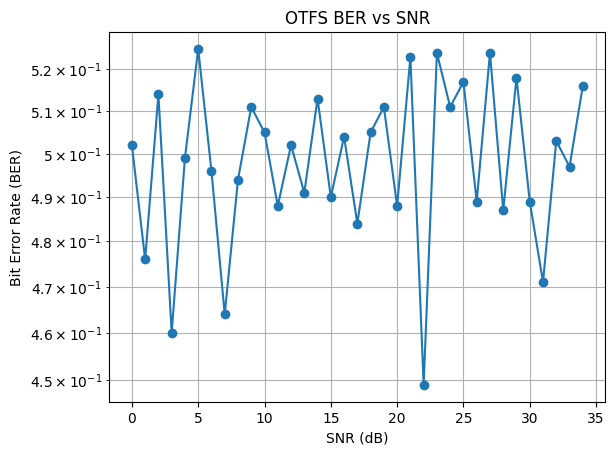

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# OTFS Modulation Functions
def ISFFT(x, M, N):
    return np.fft.ifft(np.fft.ifft(x, axis=0) / np.sqrt(M/N), axis=1)

def Heisenberg_transform(X, M):
    return np.fft.ifft(X, axis=0) * np.sqrt(M)

def Wigner_transform(r, M):
    r_mat = r.reshape(M, -1)
    return np.fft.fft(r_mat, axis=0) / np.sqrt(M)

def SFFT(Y, N, M):
    return np.fft.ifft(np.fft.ifft(Y, axis=1) / np.sqrt(N/M), axis=0)

# OTFS Channel Generation (Trivial channel for testing)
def OTFS_channel_gen():
    delay_taps = np.array([0])
    Doppler_taps = np.array([0])
    chan_coef = np.array([1+0j])
    return delay_taps, Doppler_taps, chan_coef

# OTFS Channel Output with Wireless Channel and Noise
def OTFS_channel_output(s, delay_taps, Doppler_taps, chan_coef, M, N, sigma2):
    L = max(delay_taps) if len(delay_taps) > 0 else 0
    if L > 0:
        s_cp = np.concatenate((s[-L:], s))
    else:
        s_cp = s
    s_chan = s_cp.copy()
    noise = np.sqrt(sigma2 / 2) * (np.random.randn(*s_chan.shape) + 1j * np.random.randn(*s_chan.shape))
    r = s_chan + noise
    if L > 0:
        return r[L:L + (N*M)]
    else:
        return r[:N*M]

# System parameters
M, N = 64, 16
SNRdB_range = np.arange(0, 35, 1)

# Generate input binary sequence of 1000 bits
input_bits = np.random.randint(0, 2, 1000)

total_bits = M * N
if len(input_bits) < total_bits:
    input_bits = np.concatenate([input_bits, np.zeros(total_bits - len(input_bits), dtype=int)])
else:
    input_bits = input_bits[:total_bits]

# Modulation: Convert 0s to -1s, 1s remain 1 (BPSK)
modulated_signal = 2 * input_bits - 1

# OTFS Modulation
X = ISFFT(modulated_signal.reshape(N, M), M, N)
s_mat = Heisenberg_transform(X, M)
s = s_mat.flatten()

# Calculate BER for different SNR values
BER = []
for SNRdB in SNRdB_range:
    delay_taps, Doppler_taps, chan_coef = OTFS_channel_gen()
    sigma2 = 10**(-SNRdB / 10)
    r = OTFS_channel_output(s, delay_taps, Doppler_taps, chan_coef, M, N, sigma2)
    
    # OTFS Demodulation
    Y = Wigner_transform(r, M)
    y = SFFT(Y, N, M).flatten()
    
    # Demodulation: Convert -1s back to 0s
    demodulated_bits = (np.real(y) > 0).astype(int)
    
    # Compute Bit Error Rate
    bit_errors = np.sum(input_bits[:1000] != demodulated_bits[:1000])
    BER.append(bit_errors / 1000)

# Plot BER vs SNR
plt.figure()
plt.semilogy(SNRdB_range, BER, 'o-')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('OTFS BER vs SNR')
plt.grid(True, which='both')
plt.show()